In [1]:
cd /Users/vedanglad/Desktop/Top_Det/

/Users/vedanglad/Desktop/Top_Det


In [2]:
#***********************************************************************************
# Master import
#***********************************************************************************

# Plot data in the window
%matplotlib inline
# Make the cell width the size of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import glob
import sys
import pylab
from pylab import *
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import time
import numpy as np
import os
from scipy.optimize import curve_fit
import sys, os
import numpy as np
import scipy as sp
from scipy import *
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import math

# Fontsize
font = { 'size':   24}
matplotlib.rc('font', **font)

'''
# Allow it to use Latex notation
plt.rc('text', usetex=True)
'''
# Define your own colors for the plots
mycolors = ['#c70039','#ff5733','#ff8d1a','#ffc300','#eddd53','#add45c','#57c785',
               '#00baad','#2a7b9b','#3d3d6b','#511849','#900c3f','#900c3f'] 

#***********************************************************************************
# Master import
#***********************************************************************************
print('Imports complete ...')

Imports complete ...


In [3]:
# ***********************************************************************************
# CWClass
# This class is used to import CW data and use it easily. It will use either the 
# data recorded by the computer or from the microSD Card.
#
# Arguments:
#    1. fname: 
#       location and name of the file that you want to plot
#    2. bin_size:
#       When plotting rate as a function of time, you need to specify the rate over
#       a given interval. "bin_size" is the interval in seconds. Default is 60s.
#***********************************************************************************

# This class (CWClass) simply takes a CosmicWatch data file as fname, and let's the user select the bin size.
# It converts your file from the CW detector into something more useable.

class CWClass():
    def __init__(self,fname,bin_size = 60):
        self.fname = fname.split('/')[-1]
        self.bin_size = bin_size
        
        data = np.genfromtxt(fname = fname,
                                  delimiter = '\t',dtype = str,invalid_raise=False, comments='#')
        
        for i in range(len(data[:,5])):
            try:
                data[:,5][i] = float(data[:,5][i])
            except:
                data[:,5][i] = 0
        event_number = data[:,0].astype(np.float)
        rtc_time      = data[:,1] # The realtime clock date, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        rtc_date      = data[:,2] # The realtime clock time, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        timestamp = data[:,3].astype(np.float) # a more precise time, in ms.
        adc_H     = data[:,4].astype(np.float) 
        adc_L     = data[:,5].astype(np.float)
        sipm      = data[:,6].astype(np.float) # The calculated SiPM Peak voltage.
        temp      = data[:,7].astype(np.float) # The temperature, measured during each event
        pressure  = data[:,8].astype(np.float) # The pressure, measured during each event
        deadtime   = data[:,9].astype(np.float) # The detector deadtime since the last event.
        coincident= data[:,10].astype(np.float) # Was the event coincident?
        try:
            det_names = set(data[:,11])         # Was the event coincident?
            detector = data[:,11]      
            self.n_detector       = len(set(detName))
        except:
            pass
        
        
        self.timestamp        = np.asarray(timestamp) #-  min(np.asarray(timestamp))       # The absolute time of an event in seconds
        self.timestamp_s      = np.asarray(timestamp)/1000.
        self.SiPM             = sipm
        self.temperature      = temp
        self.pressure_hpa         = pressure/100.
        self.HGain_ADC        = adc_H
        self.LGain_ADC        = adc_L
        self.select_muons       = np.asarray(coincident == 1)
        self.select_non_muons       = np.invert(self.select_muons)
        self.detector = detector
        
        self.total_counts     = len(event_number)
        self.total_muons     = len(event_number[self.select_muons])
        self.event_deadtime_us  = deadtime
        self.event_deadtime_ms  = deadtime/1000.            # an array of the measured event deadtime in miliseconds
        self.event_deadtime_s   = self.event_deadtime_ms/1000.
        self.total_deadtime_s   = sum(self.event_deadtime_s)            # an array of the measured event deadtime in miliseconds
        self.livetime = max(self.timestamp_s)- self.total_deadtime_s
        self.weights          = np.ones(len(event_number)) / self.livetime
        try:
            mjd_time_stamp = []
            for i in range(len(rtc_date)):
                year  = int(rtc_date[i].split('/')[0])
                month = int(rtc_date[i].split('/')[1])
                day   = int(rtc_date[i].split('/')[2])
                hour  = int(rtc_time[i].split(':')[0])
                mins  = int(rtc_time[i].split(':')[1])
                sec   = int(np.floor(float(rtc_time[i].split(':')[2])))
                try:  
                    decimal = float('0.'+str(rtc_time[i].split('.')[-1]))
                except:
                    decimal = 0.0
                mjd_time_stamp.append(float(time.mktime((year, month, day, hour, mins, sec, 0, 0, 0)))+ decimal) 

            self.mjd_time_stamp     = np.asarray(mjd_time_stamp) -  min(np.asarray(mjd_time_stamp))       # modified julian date
        except:
            print('Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.')
            pass
        
        bins = range(0,int(max(self.timestamp_s)), self.bin_size)
        bin_deadtime, binEdges = np.histogram(self.timestamp_s, bins = bins,weights = self.event_deadtime_s)
        
        # binned data
        counts, binEdges       = np.histogram(self.timestamp_s, bins = bins)
        
        self.count_rate       = self.total_counts/self.livetime 
        self.count_rate_err   = np.sqrt(self.total_counts)/self.livetime 
        self.event_livetime_s = diff(np.append([0],self.timestamp_s)) - self.event_deadtime_s
        self.binned_counts     = counts
        self.binned_counts_err = np.sqrt(counts)
        self.binned_count_rate = counts/(bin_size-bin_deadtime)
        self.binned_count_rate_err = np.sqrt(counts)/(bin_size-bin_deadtime)
        print("--> "+self.fname)
        print('\tTotal Count rate: '+str(np.round(self.count_rate,4)) +' +/- '+ str(np.round(self.count_rate_err,4))+'Hz')
        
        
        # Coincident binned data
        counts_muons, binEdges        = np.histogram(self.timestamp_s[self.select_muons], bins = bins)
        self.count_rate_muons       = self.total_muons/self.livetime
        self.count_rate_err_muons   = np.sqrt(self.total_muons)/self.livetime         
        self.binned_counts_muons     = counts_muons
        self.binned_counts_err_muons = np.sqrt(counts_muons)
        self.binned_count_rate_muons = counts_muons/(bin_size-bin_deadtime)
        self.binned_count_rate_err_muons = np.sqrt(counts_muons)/(bin_size-bin_deadtime)
        print('\tCoincident Count rate: '+str(np.round(self.count_rate_muons,4)) +' +/- '+ str(np.round(self.count_rate_err_muons,4))+'Hz')
        
        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        self.bin_size          = bin_size
        self.binned_time_s     = bincenters
        self.binned_time_m     = bincenters/60.
    
        
def plusSTD(n,array):
    xh = np.add(n,np.sqrt(np.abs(array)))
    return xh

def subSTD(n,array):
    xl = np.subtract(n,np.sqrt(np.abs(array)))
    return xl

def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None,lw=2, **kwargs):
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = sp.repeat((x[1:] - x[:-1]), 2)
    xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
    # Now: add one step at end of row.
    xx = sp.append(xx, xx.max() + xstep[-1])

    # Make it possible to chenge step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == sp.ndarray:
        y2 = y2.repeat(2)#[:-1]

    # now to the plotting part:
    ax.fill_between(xx, y1, y2=y2,lw=lw, **kwargs)
    return ax

print('Definitions complete ...')

Definitions complete ...


In [4]:
class NPlot():
    def __init__(self, 
                 data,
                 weights,
                 colors,
                 labels,
                 xmin,xmax,ymin,ymax,
                 figsize = [10,10],fontsize = 18,nbins = 101, alpha = 0.9,
                 xscale = 'log',yscale = 'log',xlabel = '',loc = 1,pdf_name='',lw=2, title=''):
        
        fig = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = fig.add_subplot(111)

        if xscale == 'log':
            bins = np.logspace(np.log10(xmin),np.log10(xmax),nbins)
        if xscale == 'linear':
            bins = np.linspace(xmin,xmax,nbins)
    
        for i in range(len(data)):
            counts,binEdges = np.histogram(data[i][~np.isnan(data[i])],bins = bins,weights = weights[i][~np.isnan(weights[i])],range= (200,1024))
            bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
            sumWeightsSqrd, binEdges = np.histogram(data[i][~np.isnan(data[i])], bins = bins, weights = np.power(weights[i][~np.isnan(weights[i])],2),range= (200,1024))
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd),subSTD(counts,sumWeightsSqrd),  color = colors[i],alpha = alpha,lw=lw)
            pylab.plot([1e14,1e14], label = labels[i],color = colors[i],alpha = alpha,linewidth = 2)
        
        pylab.yscale(yscale, nonposy='clip')
        pylab.xscale(xscale, nonposx='clip')
        pylab.grid(b=True, which='major', color='k', alpha = 0.1,linestyle='-')
        pylab.grid(b=True, which='minor', color='k',alpha = .05,  linestyle='-')
        pylab.legend(fontsize=fontsize-2,loc = loc,  fancybox = True,frameon=True)
        pylab.ylabel(r'Rate/bin [s$^{-1}$]',size=fontsize)
        pylab.xlabel(xlabel, labelpad=20,size=fontsize)
        pylab.axis([xmin, xmax, ymin,ymax])
        plt.title(title,fontsize=fontsize)
        pylab.tight_layout()
        if pdf_name != '':
            plt.savefig(pdf_name, format='pdf',transparent =True)
        pylab.show()



In [5]:
# Load data that was taken from a computer
#    1. Give the name of the file
#    2. Give the size of binning in time you would like
cwd = os.getcwd()
f1 = CWClass(cwd + "/FileC004.txt", bin_size = 60)
f2 = CWClass(cwd + "/FileC005.txt", bin_size = 60)
f3 = CWClass(cwd + "/FileC006.txt", bin_size = 60)
f4 = CWClass(cwd + "/FileC007.txt", bin_size = 60)

<ipython-input-3-e7fe503a4ec3>:65: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  self.total_deadtime_s   = sum(self.event_deadtime_s)            # an array of the measured event deadtime in miliseconds
<ipython-input-3-e7fe503a4ec3>:96: DeprecationWarning: scipy.diff is deprecated and will be removed in SciPy 2.0.0, use numpy.diff instead
  self.event_livetime_s = diff(np.append([0],self.timestamp_s)) - self.event_deadtime_s


Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.
--> FileC004.txt
	Total Count rate: 15.0772 +/- 0.044Hz
	Coincident Count rate: 3.0732 +/- 0.0199Hz
Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.
--> FileC005.txt
	Total Count rate: 4.8833 +/- 0.0347Hz
	Coincident Count rate: 1.1214 +/- 0.0166Hz
Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.
--> FileC006.txt
	Total Count rate: 9.8344 +/- 0.0487Hz
	Coincident Count rate: 2.0905 +/- 0.0224Hz
Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.
--> FileC007.txt
	Total Count rate: 5.7157 +/- 0.0351Hz
	Coincident Count rate: 1.2579 +/- 0.0165Hz


In [6]:
all_flights=[f1,f2,f3,f4]

<ipython-input-3-e7fe503a4ec3>:136: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  xstep = sp.repeat((x[1:] - x[:-1]), 2)
<ipython-input-3-e7fe503a4ec3>:137: DeprecationWarning: scipy.concatenate is deprecated and will be removed in SciPy 2.0.0, use numpy.concatenate instead
  xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
<ipython-input-3-e7fe503a4ec3>:139: DeprecationWarning: scipy.append is deprecated and will be removed in SciPy 2.0.0, use numpy.append instead
  xx = sp.append(xx, xx.max() + xstep[-1])
<ipython-input-4-f8f821a61b65>:26: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pylab.yscale(yscale, nonposy='clip')
<ipython-input-4-f8f821a61b65>:27: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.

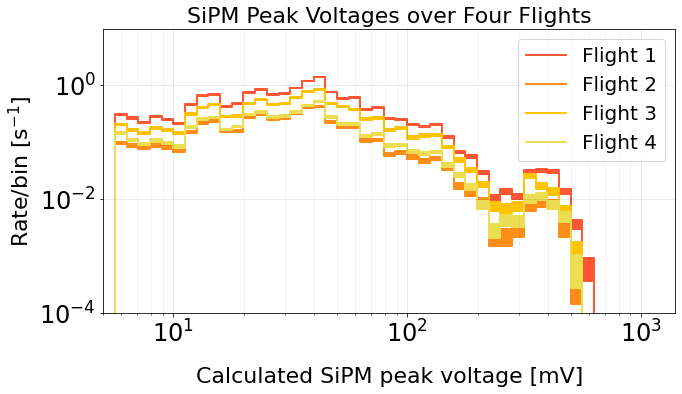

In [7]:
# Plot data
c = NPlot(data = [f1.SiPM,f2.SiPM, f3.SiPM, f4.SiPM], 
    weights = [f1.weights, f2.weights, f3.weights, f4.weights],
    colors = [mycolors[1],mycolors[2], mycolors[3], mycolors[4]],
    labels = [r'Flight 1',r'Flight 2',r'Flight 3',r'Flight 4'],
    figsize = [10,6],
    fontsize = 22,
    xmin = 5, xmax = 1400,ymin =0.1e-3,ymax = 10,
    nbins =  50, alpha = 1, lw=2,
    xscale = 'log',yscale = 'log',
    xlabel = 'Calculated SiPM peak voltage [mV]',
    title = 'SiPM Peak Voltages over Four Flights',
    loc = 1, pdf_name='')

#  Rate plot

In [8]:
class ratePlot():
    def __init__(self,
                 time,
                 count_rates,
                 count_rates_err,
                 colors,
                 labels,
                 xmin,xmax,ymin,ymax,
                 figsize = [10,10],fontsize = 18, alpha = 0.9,
                 xscale = 'linear',yscale = 'linear',
                 xlabel = '',ylabel = '',
                 loc = 1,pdf_name='',title = '', plotfit=None):
        
        f = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = f.add_subplot(111)

        for i in range(len(count_rates)):
            try:
                pylab.errorbar(time[i], 
                               count_rates[i],
                               xerr=0, yerr=count_rates_err[i],
                               fmt= 'ko',label = labels[i], linewidth = 2, ecolor = colors[i], markersize = 2)
            except:
                pylab.errorbar(time[i], 
                               count_rates[i],
                               xerr=0, yerr=count_rates_err[i],
                               fmt= 'ko', linewidth = 2, ecolor = colors[0], markersize = 2)
                
            if plotfit is not None:
                for i in range(len(count_rates)):       
                    pylab.plot(time[i],plotfit[0](time[i],*plotfit[1]), linestyle="-",label="Best Fit Using Flight Altitude Data")

        pylab.yscale(yscale)
        pylab.xscale(xscale)
#         pylab.yscale(yscale, nonposy='clip')
#         pylab.xscale(xscale, nonposx='clip')
        pylab.ylabel(ylabel)
        pylab.xlabel(xlabel)
        pylab.axis([xmin, xmax, ymin,ymax])
        #ax1.xaxis.set_label_coords(0.5, 0.3)
        ax1.xaxis.labelpad = 0 
        pylab.legend(loc=loc, shadow=True,fontsize = 24,frameon = 0,fancybox = True)
        pylab.tight_layout()
        plt.title(title)
        if pdf_name != '':
            plt.savefig(pdf_name, format='pdf',transparent =True)
            
        


            
        pylab.show()
        

In [9]:
total=list(f1.binned_time_s)
for index in range(1,4):
    total.extend(all_flights[index].binned_time_s+max(total))

In [10]:
count_rates = list(f1.binned_count_rate)+list(f2.binned_count_rate)+list(f3.binned_count_rate)+list(f4.binned_count_rate)
count_rates_err = list(f1.binned_count_rate_err)+list(f2.binned_count_rate_err)+list(f3.binned_count_rate_err)+list(f4.binned_count_rate_err)

In [11]:
len(count_rates_err)

369

In [12]:
len(count_rates)

369

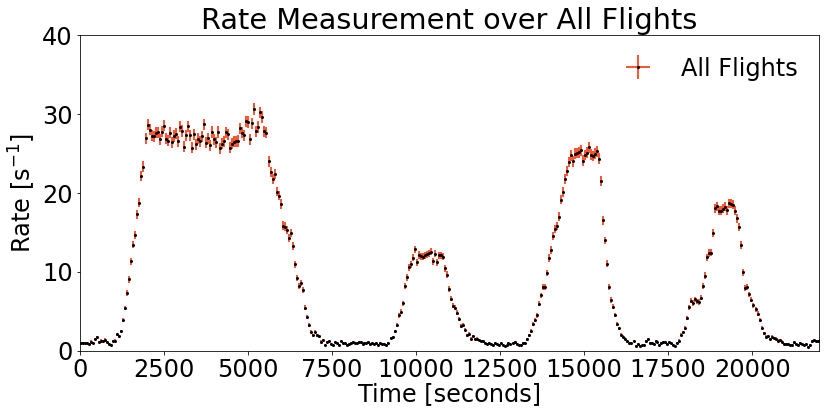

In [13]:
c = ratePlot(time = total,
             count_rates = count_rates,
             count_rates_err = count_rates_err,
             colors =[mycolors[1]],
             labels = [r'All Flights'],
             xmin = 0,xmax = 22000,ymin = 0,ymax = 40,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [seconds]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over All Flights')



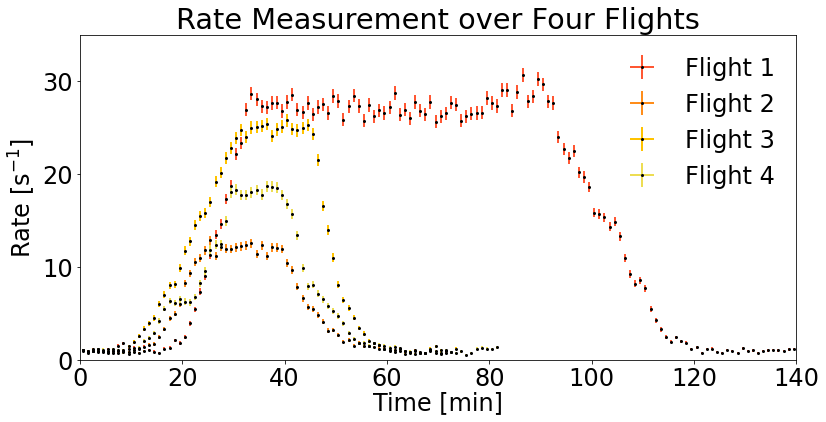

In [14]:
c = ratePlot(time = [f1.binned_time_m,f2.binned_time_m,f3.binned_time_m,f4.binned_time_m],
             count_rates = [f1.binned_count_rate,f2.binned_count_rate,f3.binned_count_rate,f4.binned_count_rate],
             count_rates_err = [f1.binned_count_rate_err,f2.binned_count_rate_err,f3.binned_count_rate_err,f4.binned_count_rate_err],
             colors =[mycolors[1],mycolors[2], mycolors[3], mycolors[4]],
             labels = [r'Flight 1',r'Flight 2',r'Flight 3',r'Flight 4'],
             xmin = 0,xmax = 140,ymin = 0,ymax = 35,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over Four Flights')



In [15]:
print(np.mean(f1.binned_count_rate), np.mean(f2.binned_count_rate), np.mean(f3.binned_count_rate),np.mean(f4.binned_count_rate))

15.416681610392555 4.93536353846757 10.096381541049826 5.825828278765305


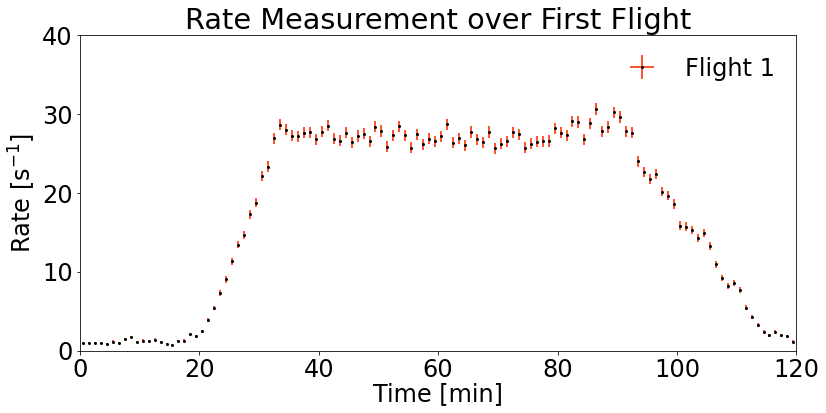

In [16]:
# Play around with the settings.
# If the labelling looks small, rerun the master import a few cells above.


c = ratePlot(time = [f1.binned_time_m],
             count_rates = [f1.binned_count_rate],
             count_rates_err = [f1.binned_count_rate_err],
             colors =[mycolors[1],mycolors[2], mycolors[3], mycolors[4]],
             labels = [r'Flight 1'],
             xmin = 0,xmax = 120,ymin = 0,ymax = 40,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over First Flight')

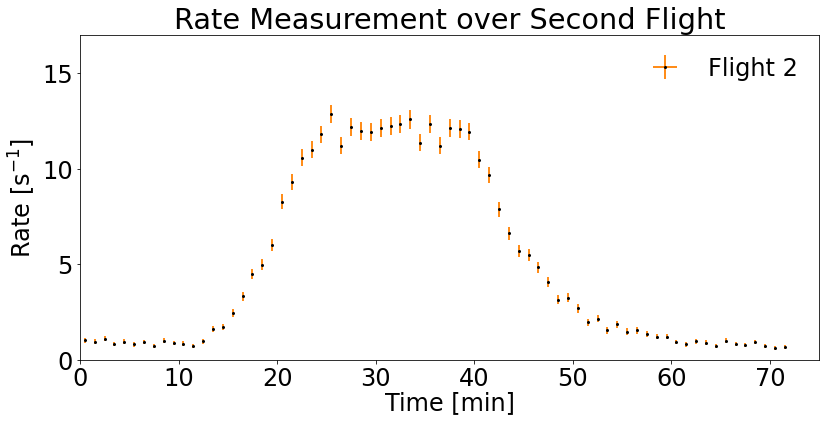

In [17]:
c = ratePlot(time = [f2.binned_time_m],
             count_rates = [f2.binned_count_rate],
             count_rates_err = [f2.binned_count_rate_err],
             colors =[mycolors[2]],
             labels = [r'Flight 2'],
             xmin = 0,xmax = 75,ymin = 0,ymax = 17,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over Second Flight')



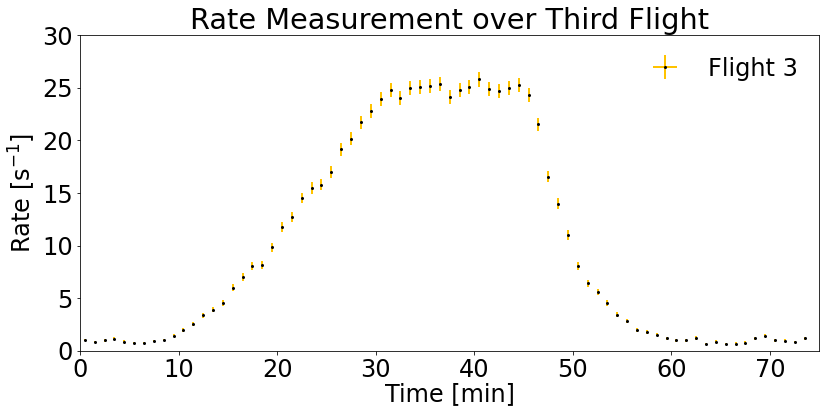

In [18]:
c = ratePlot(time = [f3.binned_time_m],
             count_rates = [f3.binned_count_rate],
             count_rates_err = [f3.binned_count_rate_err],
             colors =[mycolors[3]],
             labels = [r'Flight 3'],
             xmin = 0,xmax = 75,ymin = 0,ymax = 30,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over Third Flight')




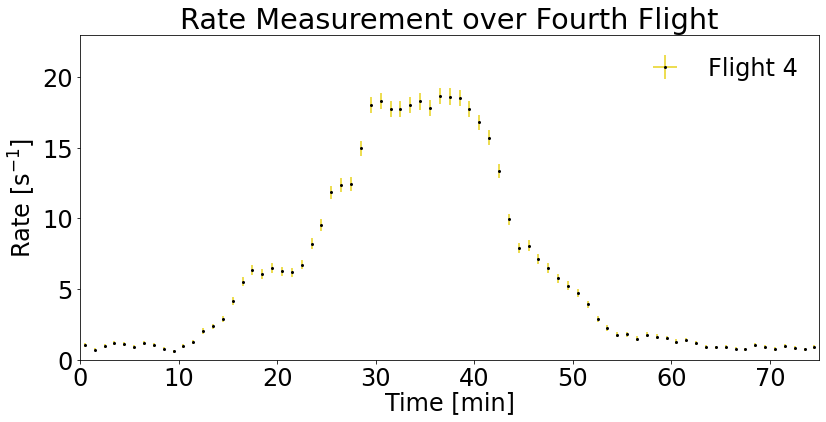

In [19]:
c = ratePlot(time = [f4.binned_time_m],
             count_rates = [f4.binned_count_rate],
             count_rates_err = [f4.binned_count_rate_err],
             colors =[mycolors[4]],
             labels = [r'Flight 4'],
             xmin = 0,xmax = 75,ymin = 0,ymax = 23,
             figsize = [12,6],fontsize = 20,alpha = 1,
             xscale = 'linear',yscale = 'linear',xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
             loc = 1,pdf_name='',title = 'Rate Measurement over Fourth Flight')





In [20]:
cd /Users/vedanglad/Documents/JLab/Cosmic_watch_data/

/Users/vedanglad/Documents/JLab/Cosmic_watch_data


In [21]:
import pandas as pd
from scipy.interpolate import interp1d

In [22]:
def alt_to_rate(t,a,b,c,d):
    return a*np.exp(b*interp(t-c))+d

[ 1.06909314e+00  2.98115782e-01  8.66129199e+02 -3.61636401e-01]
304.16677846069854
6.8833827526759706e-15


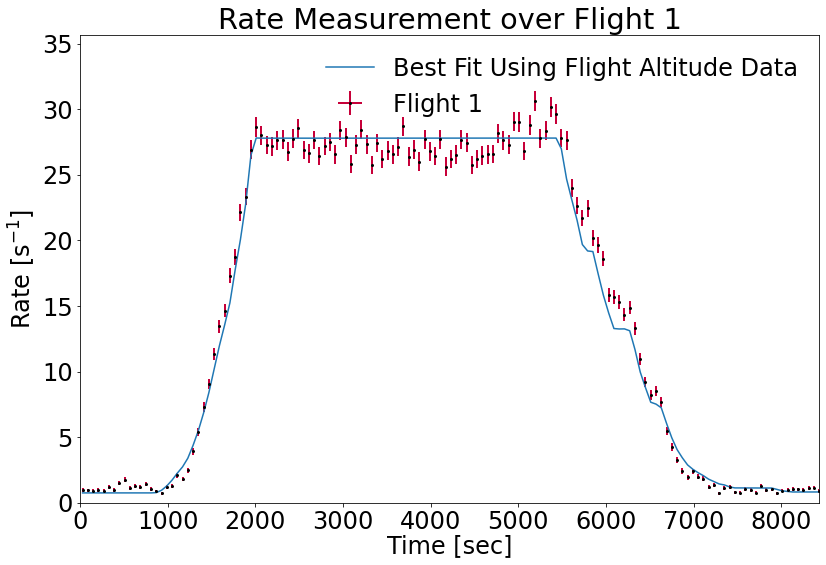

[3.98815379e-01 4.27278632e-01 6.11046944e+02 2.89518802e-01]
25.55666754394612
0.9999989731273143


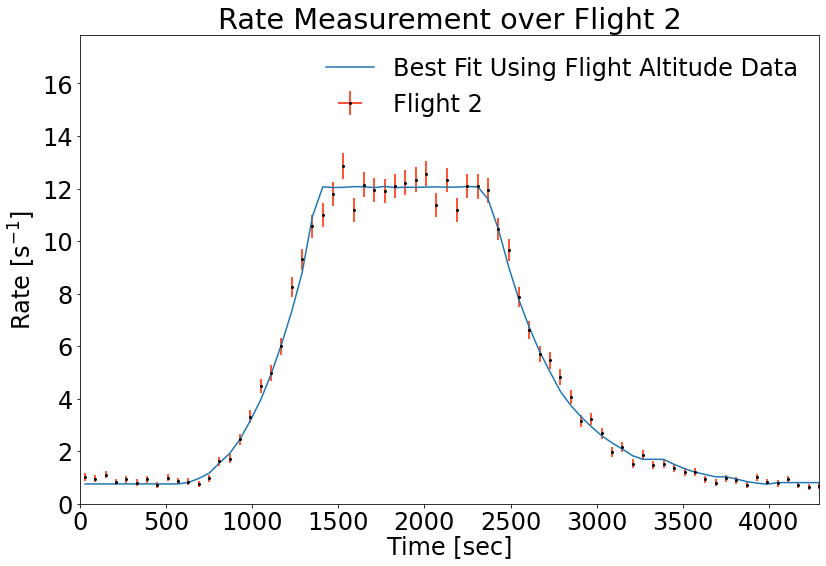

[ 8.00292535e-01  3.24949399e-01  3.26411445e+02 -1.43377229e-01]
62.881766358066926
0.6843300400839532


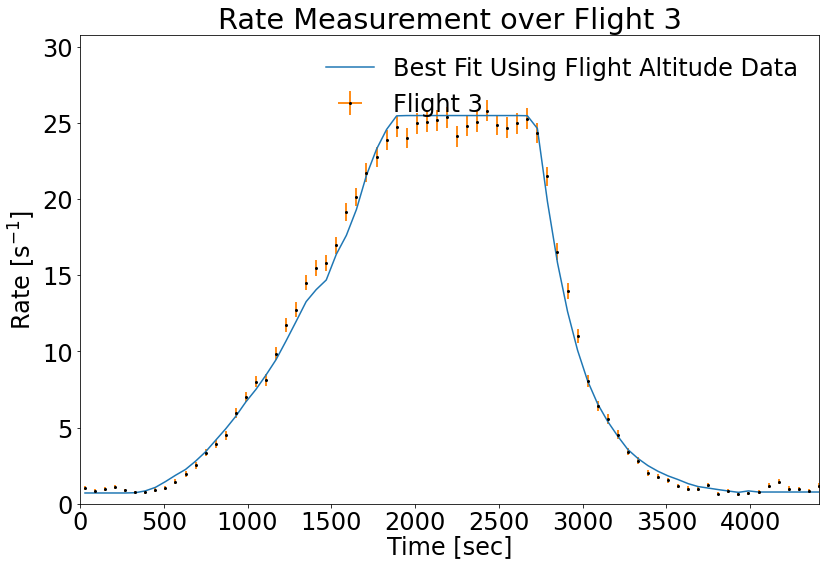

[5.56734656e-01 3.72086455e-01 5.23616319e+02 1.64306876e-01]
49.88961055103333
0.9929724424245644


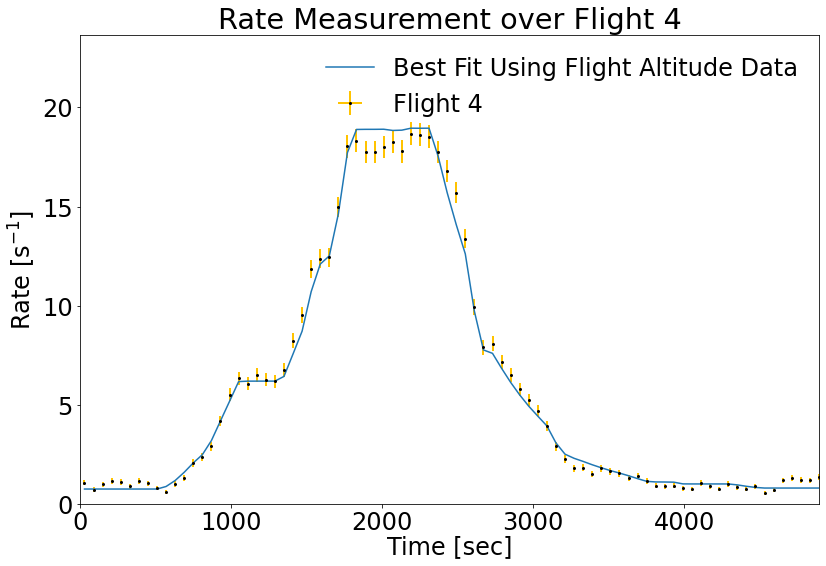

In [61]:
for index in range(len(all_flights)):
    flight=all_flights[index]
    df=pd.read_csv(f"flight{index+1}.csv")
    
    start=df['Time (EST)'][0][4:12]
    start_date=date_time = datetime.datetime.strptime(start, "%H:%M:%S")
    secs=[]
    for time in df['Time (EST)']:

        time_string = time[4:12]
        date_time = datetime.datetime.strptime(time_string, "%H:%M:%S")
        a_timedelta = date_time - start_date
        seconds = a_timedelta.total_seconds()
        secs.append(seconds)
    
    ys=[float(element.replace(',', ''))*0.0003048 for element in df["feet"]]
    interp = interp1d(secs,ys, kind='cubic',bounds_error=False,fill_value=(ys[0],ys[1]))
    fit = curve_fit(alt_to_rate, flight.binned_time_s, flight.binned_count_rate, [0.719, 0.34, 500, 0.4], flight.binned_count_rate_err, maxfev=500000) # find the best fit with curve_fit
    popt, pcov = fit
    print(popt)
    r = flight.binned_count_rate - alt_to_rate(flight.binned_time_s, *popt)
    chisq = np.sum((r ** 2/ flight.binned_count_rate_err) )
    print(chisq)
    print(1 - stats.chi2.cdf(chisq,len(flight.binned_count_rate)-5))
    
    
    ratePlot(time = [flight.binned_time_s],
         count_rates = [flight.binned_count_rate],
         count_rates_err = [flight.binned_count_rate_err],
         colors =[mycolors[index]],
         labels = [f'Flight {index+1}'],
         xmin = 0,xmax =max(flight.binned_time_s)+3 ,ymin = 0,ymax = max(flight.binned_count_rate)+5,
         figsize = [12,8],fontsize = 20,alpha = 1,
         xscale = 'linear',yscale = 'linear',xlabel = 'Time [sec]',ylabel = r'Rate [s$^{-1}$]',
         loc = 1,pdf_name='',title = f'Rate Measurement over Flight {index+1}', plotfit=(alt_to_rate,fit[0]))


266 265


<ipython-input-60-224e289a2d51>:29: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  count_rates_err = [sqrt(x) for x in all_count_rates],


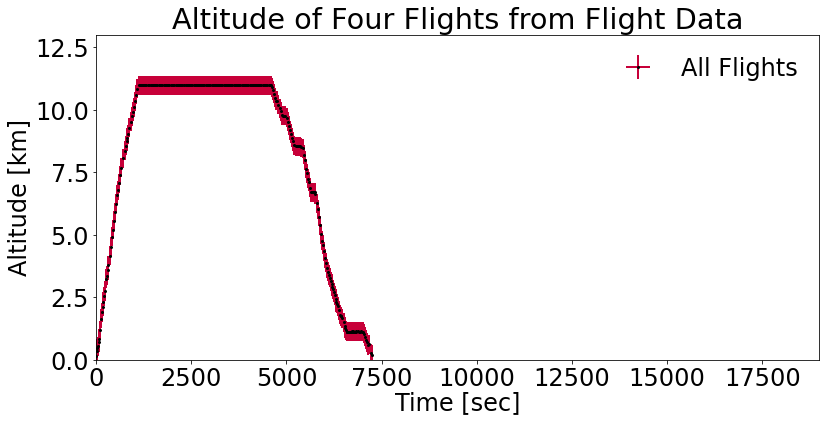

390 389


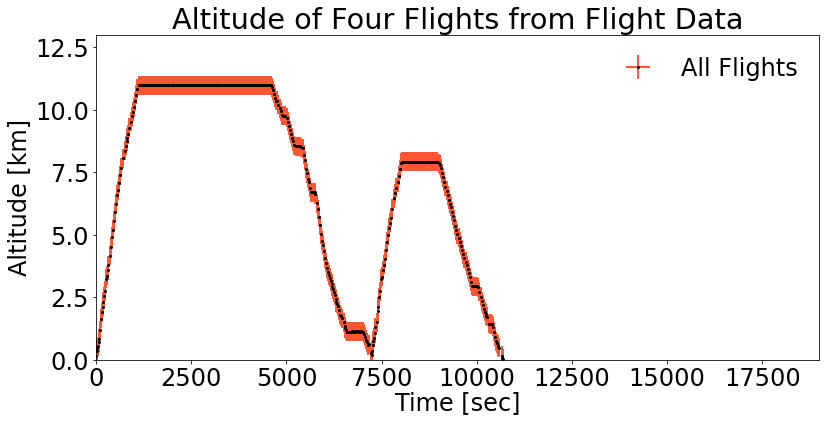

525 524


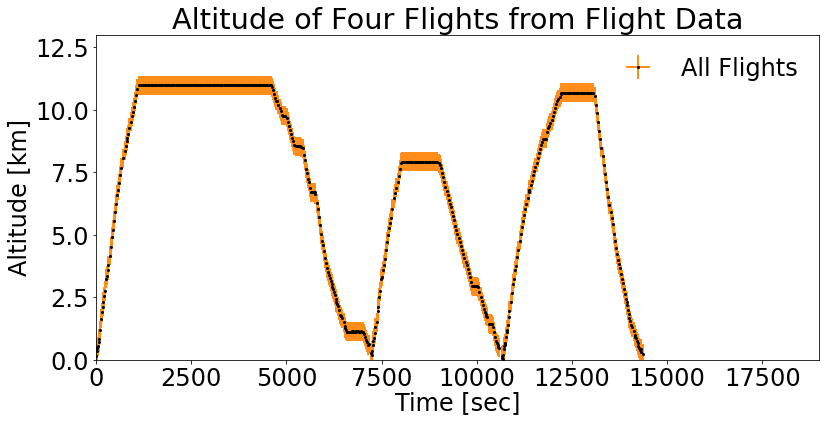

674 673


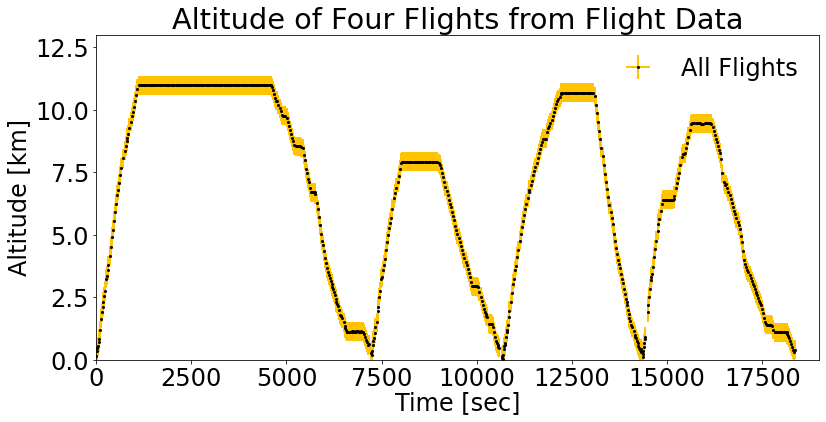

In [60]:
total=[0]
all_count_rates=[]
for index in range(len(all_flights)):
    
    
    flight=all_flights[index]
    df=pd.read_csv(f"flight{index+1}.csv")
    
    start=df['Time (EST)'][0][4:12]
    start_date=date_time = datetime.datetime.strptime(start, "%H:%M:%S")
    secs=[]
    for time in df['Time (EST)']:

        time_string = time[4:12]
        date_time = datetime.datetime.strptime(time_string, "%H:%M:%S")
        a_timedelta = date_time - start_date
        seconds = a_timedelta.total_seconds()
        secs.append(seconds)
    
    ys=[float(element.replace(',', ''))*0.0003048 for element in df["feet"]]
    total.extend(secs+np.max(total))
    
    all_count_rates.extend(ys)
    
    print(len(total), len(all_count_rates))
    
    

    ratePlot(time = [total[1:]],
         count_rates = [all_count_rates],
         count_rates_err = [sqrt(x) for x in all_count_rates],
         colors =[mycolors[index]],
         labels = [f'All Flights'],
         xmin = 0,xmax =19000 ,ymin = 0,ymax = 13,
         figsize = [12,6],fontsize = 20,alpha = 1,
         xscale = 'linear',yscale = 'linear',xlabel = 'Time [sec]',ylabel = r'Altitude [km]',
         loc = 1,pdf_name='',title = f'Altitude of Four Flights from Flight Data')

